In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from sklearn.metrics import classification_report

X = np.load('flower_species_classification/data_train.npy').T/255.0
t = np.load('flower_species_classification/labels_train.npy')

# Downsample images to 150x150
X[0].reshape(300,300,3)[::2,::2].shape
X_downsampled = X.reshape(X.shape[0],300,300,3)[::1,::2,::2,::1]
X_downsampled.shape

class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 'Marigold', 
               'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']

# 80/20 train-val split
from sklearn.model_selection import train_test_split
X_train, X_val, t_train, t_val = train_test_split(X_downsampled, t, shuffle=True, stratify=t, test_size=0.2)
X_train.shape, t_train.shape, X_val.shape, t_val.shape

((1326, 150, 150, 3), (1326,), (332, 150, 150, 3), (332,))

In [2]:
# Create TensorFlow objects
import tensorflow as tf
from tensorflow import keras
X_train_rs = tf.constant(X_train.reshape((X_train.shape[0],150,150,3)), dtype=tf.float32)
X_val_rs = tf.constant(X_val.reshape((X_val.shape[0],150,150,3)), dtype=tf.float32)

print('TF Training Object shape: ', X_train_rs.shape, '\nTF Validation Object shape: ', X_val_rs.shape)

2022-12-10 22:38:38.794529: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 22:38:39.318195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


TF Training Object shape:  (1326, 150, 150, 3) 
TF Validation Object shape:  (332, 150, 150, 3)


In [3]:
# Create Model
def create_model(transfer_layer=keras.applications.Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False),
                 units=100,
                 activation_function='selu',
                 kernel_init='lecun_normal',
                 dropout=0.2,
                 learning_rate=0.001):
    # Construct Model
    model = keras.models.Sequential([
        transfer_layer,
        keras.layers.Flatten(),
        #keras.layers.GlobalAveragePooling2D(),
        #keras.layers.Dense(300, activation='relu'),
        keras.layers.Dense(units, activation=activation_function, kernel_initializer=kernel_init),
        keras.layers.Dropout(rate=dropout),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [4]:
# Baseline Model
model = create_model()
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
#model.save('saved_models/baseline.h5')

Epoch 1/10


2022-12-10 22:38:49.924272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-12-10 22:38:50.952216: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-12-10 22:38:51.116109: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-10 22:38:52.196739: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42/42 [==============================] - 12s 133ms/step - loss: 2.5955 - accuracy: 0.1456 - val_loss: 2.9836 - val_accuracy: 0.2530
Epoch 2/10
42/42 [==============================] - 5s 108ms/step - loss: 2.1871 - accuracy: 0.1998 - val_loss: 3.5021 - val_accuracy: 0.1807
Epoch 3/10
42/42 [==============================] - 5s 107ms/step - loss: 2.0557 - accuracy: 0.2104 - val_loss: 9.7052 - val_accuracy: 0.2108
Epoch 4/10
42/42 [==============================] - 5s 108ms/step - loss: 2.0187 - accuracy: 0.2391 - val_loss: 2.6195 - val_accuracy: 0.2590
Epoch 5/10
42/42 [==============================] - 5s 109ms/step - loss: 1.9055 - accuracy: 0.2858 - val_loss: 19.8690 - val_accuracy: 0.2380
Epoch 6/10
42/42 [==============================] - 5s 109ms/step - loss: 1.7398 - accuracy: 0.3529 - val_loss: 2.7061 - val_accuracy: 0.3494
Epoch 7/10
42/42 [==============================] - 4s 104ms/step - loss: 1.6419 - accuracy: 0.4291 - val_loss: 22.8847 - val_accuracy: 0.2289
Epoch 8/10
42/

               precision    recall  f1-score   support

        Roses       0.13      0.50      0.21       141
    Magnolias       0.66      0.51      0.57       144
       Lilies       0.42      0.58      0.49       164
   Sunflowers       0.94      0.74      0.83       112
      Orchids       0.56      0.88      0.69       138
     Marigold       0.00      0.00      0.00       125
     Hibiscus       0.19      0.23      0.20       128
     Firebush       0.00      0.00      0.00       138
       Pentas       0.00      0.00      0.00       130
Bougainvillea       0.00      0.00      0.00       106

     accuracy                           0.36      1326
    macro avg       0.29      0.34      0.30      1326
 weighted avg       0.29      0.36      0.31      1326



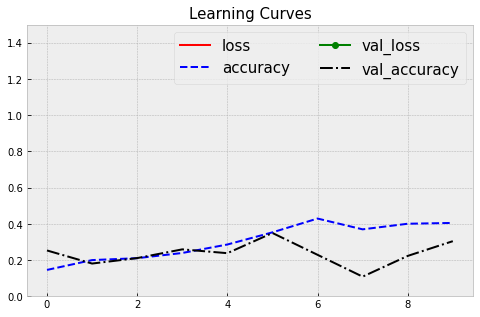

In [5]:
key_names = list(history.history.keys())
colors = ['-r','--b','-og','-.k']
plt.figure(figsize=(8,5))
plt.ylim(top=1.5)
for i in range(len(key_names)):
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);
# Model's Predictions
y_train = np.argmax(model.predict(X_train_rs),axis=1)
print(classification_report(t_train, y_train, target_names=class_names))

In [ ]:
# Tuning for pre-trained model

# VGG16
transfer_layer = keras.applications.VGG16(weights='imagenet', input_shape=(150, 150, 3), include_top=False)
transfer_layer.trainable = False
model = create_model(transfer_layer)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/VGG16.h5')

# VGG19
transfer_layer = keras.applications.VGG19(weights='imagenet', input_shape=(150, 150, 3), include_top=False)
transfer_layer.trainable = False
model = create_model(transfer_layer)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/VGG19.h5')

In [ ]:
# Tuning for number of units in first hidden layer

# 1600 units
model = create_model(units=1600)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/units_1600.h5')

# 20 units
model = create_model(units=20)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/units_20.h5')

In [ ]:
# Tuning for activation function of hidden layer

# ReLU
model = create_model(activation_function='relu')
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/relu.h5')

# Tanh
model = create_model(activation_function='tanh')
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/tanh.h5')

In [ ]:
# Tuning for kernel initializer of hidden layer

# He
model = create_model(kernel_init='he_normal')
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/he.h5')

# Glorot
model = create_model(kernel_init='glorot_normal')
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/glorot.h5')

In [ ]:
# Tuning for dropout

# 0.5
model = create_model(dropout=0.5)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/dropout_0.5.h5')

# 0.8
model = create_model(dropout=0.8)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/dropout_0.8.h5')

In [ ]:
# Tuning for learning rate

# 0.03
model = create_model(learning_rate=0.003)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/learning_rate_0.003.h5')

# 0.01
model = create_model(learning_rate=0.01)
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/learning_rate_0.01.h5')

In [ ]:
# Tuning for number of epochs

# 20 passes
model = create_model()
history = model.fit(X_train_rs, t_train, epochs=20, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/epochs_20.h5')

# 30 passes
history = model.fit(X_train_rs, t_train, epochs=30, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/epochs_30.h5')

In [ ]:
# Tuning for batch size

# 64
model = create_model()
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 64, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/batch_64.h5')

# 10
history = model.fit(X_train_rs, t_train, epochs=10, batch_size = 10, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
model.save('saved_models/batch_10.h5')

In [ ]:
# Tuning for checkpoints

# save best only
model = create_model()
history = model.fit(X_train_rs, t_train, epochs=5, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)])
model.save('saved_models/checkpoints.h5')

In [ ]:
# Tuning for hidden layers

# 2 hidden layers
transfer_layer=keras.applications.Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False)
model = keras.models.Sequential([
    transfer_layer,
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation='selu'),
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(X_train_rs, t_train, epochs=5, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)])
model.save('saved_models/hidden_layers_2.h5')

# 3 hidden layers
transfer_layer=keras.applications.Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False)
model = keras.models.Sequential([
    transfer_layer,
    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation='selu'),
    keras.layers.Dense(300, activation='selu'),
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(X_train_rs, t_train, epochs=5, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)])
model.save('saved_models/hidden_layers_3.h5')

In [ ]:
# Creating model with best independent design choices and hyperparameters

transfer_layer=keras.applications.VGG16(weights='imagenet', input_shape=(150, 150, 3), include_top=False)
model = keras.models.Sequential([
    transfer_layer,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='tanh'),
    keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(X_train_rs, t_train, epochs=5, batch_size = 32, 
                        validation_data=(X_val_rs, t_val), callbacks=[keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)])
model.save('saved_models/test_model.h5')